In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scipy.stats as ss
from pandas_datareader import DataReader
from datetime import datetime

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
facebook = DataReader('FB',  'yahoo', datetime(2016,4,1), datetime(2019,9,1));
facebook.reset_index(inplace=True,drop=False)
facebook.set_index('Date')
facebook['OpenTmr'] = facebook['Open'].shift(-1)
facebook['OpenClose']= (facebook['Open']+ facebook['Close'])/2
facebook['HighLow'] = (facebook['High']+ facebook['Low'])/2
facebook['OCHL'] = (facebook['Open']+ facebook['Close']+facebook['High']+ facebook['Low'])/4
facebook

,Date,High,Low,Open,Close,Volume,Adj Close,OpenTmr,OpenClose,HighLow,OCHL
0,2016-03-31,115.010002,113.769997,114.699997,114.099998,21207500,114.099998,113.750000,114.399998,114.389999,114.394999
1,2016-04-01,116.169998,113.349998,113.750000,116.059998,24760500,116.059998,114.070000,114.904999,114.759998,114.832499
2,2016-04-04,114.550003,111.610001,114.070000,112.550003,48487900,112.550003,112.110001,113.310001,113.080002,113.195002
3,2016-04-05,113.320000,111.900002,112.110001,112.220001,22962400,112.220001,112.470001,112.165001,112.610001,112.387501
4,2016-04-06,113.809998,112.419998,112.470001,113.709999,20814600,113.709999,113.790001,113.090000,113.114998,113.102499
...,...,...,...,...,...,...,...,...,...,...,...
857,2019-08-26,180.500000,178.240005,179.399994,180.360001,8773600,180.360001,181.929993,179.879997,179.370003,179.625000
858,2019-08-27,184.039993,181.009995,181.929993,181.300003,14399600,181.300003,180.529999,181.614998,182.524994,182.069996
859,2019-08-28,181.949997,178.919998,180.529999,181.759995,9386100,181.759995,183.770004,181.144997,180.434998,180.789997
860,2019-08-29,186.080002,183.470001,183.770004,185.570007,10128700,185.570007,186.779999,184.670006,184.775002,184.722504


In [3]:
N = facebook.shape[0] # total num days
num_boot = 1# total num bootstrap
T= 250 # start day
window = 200 # training period window
Y =facebook['OpenTmr'][-(N-(T+1)):].values

In [4]:
from sklearn.svm import SVR  


def svm_train(X_train, Y_train, X_pred):  
   
    svr_model = SVR(kernel='rbf', gamma=0.0005)
    result = svr_model.fit(X_train, Y_train)
 
    y_hat = result.predict(X_train)  
    y_pred = result.predict(X_pred)
    rmse_svm=np.sqrt(np.mean((Y_train-y_hat)**2))
    return y_hat, y_pred, rmse_svm

In [5]:
def svm_bstr():
    num_boot = 1
    yhat_svm = np.zeros(N-(T+1))
    for t in range(T+1, N):    
        X_train = facebook[['Close']][t-window:t-1] 
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        X_pred = facebook[['Close']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        Y_train = facebook['OpenTmr'][t-window:t-1].values    
        yhat_train = svm_train(X_train, Y_train, X_pred)[0] 
        res_train =  Y_train - yhat_train        
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err                        
            y_pred_bstr = svm_train(X_train, y_bstr, X_pred)[1]
            y_pred_all[i]=y_pred_bstr
          
        y_pred_svm = y_pred_all.mean() # mean of all bootstrap predictions
        yhat_svm[t-(T+1)]=y_pred_svm # do this for each time step        
    rmse_svm=np.sqrt(np.mean((Y[:-1]-yhat_svm[:-1])**2))
    return yhat_svm, rmse_svm

In [6]:
rmse = svm_bstr()[1]

In [7]:
rmse

7.316461340113

In [11]:
X = facebook[['Open']]
Y = facebook[['Open']].values
Y


array([[114.69999695],
       [113.75      ],
       [114.06999969],
       [112.11000061],
       [112.47000122],
       [113.79000092],
       [114.25      ],
       [110.69999695],
       [109.33999634],
       [112.23000336],
       [110.62000275],
       [110.79000092],
       [109.73999786],
       [111.09999847],
       [112.43000031],
       [112.55000305],
       [111.20999908],
       [109.87000275],
       [110.48999786],
       [107.94000244],
       [119.58000183],
       [116.81999969],
       [117.83000183],
       [117.51999664],
       [116.61000061],
       [118.04000092],
       [117.16000366],
       [119.54000092],
       [119.62000275],
       [120.41000366],
       [119.98000336],
       [120.37999725],
       [119.37999725],
       [118.81999969],
       [116.80000305],
       [117.05000305],
       [116.95999908],
       [117.41999817],
       [116.23999786],
       [118.12999725],
       [118.23999786],
       [119.55999756],
       [119.45999908],
       [118

In [18]:
svr_model = SVR(kernel='rbf', gamma=0.0005)
result = svr_model.fit(X, Y)
 
y_hat = result.predict(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


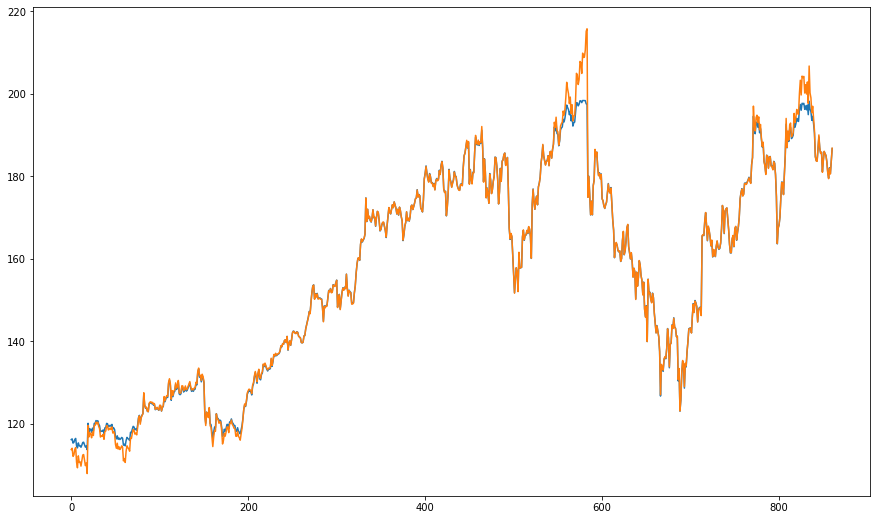

In [19]:
plt.plot(y_hat)
plt.plot(Y)

## Professionalism
50% Minghao Ru

50% Tong Yang


## Licensing
Copyright <2020> Minghao Ru, Tong Yang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.